In [1]:
import influxdb_client
print("Influxdb_client Version : {}".format(influxdb_client.__version__))
from influxdb_client import InfluxDBClient

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bokeh.io import (output_notebook,
                      show,
                      # push_notebook,
                      #curdoc,
                      )
from bokeh.models import (ColumnDataSource,
                          DatetimeTickFormatter,
                          NumeralTickFormatter,
                          LinearAxis, 
                          Range1d,
                          HoverTool,)
from bokeh.plotting import figure
from scipy.stats import linregress, t
import control as ct

Influxdb_client Version : 1.48.0


# install pip packages in Jupyterlab
import sys  
!{sys.executable} -m pip install --upgrade influxdb_client


In [2]:
# @title
client = InfluxDBClient(url='http://kane584.tecnico.ulisboa.pt:8086',
                        token='H1H3MkH8E3L_HUEDJRFLhQuFOyUWR87_bjvgqXda7KzZnzQF3aN4NQs9OrYTJixsqslcyAXsJzP4j41-uRiz4Q==',
                        org='7ffb1a7998038e38')
query_api = client.query_api()

In [3]:
# @title Get saved Data
DATE  = '2025-03-13'
START = 'T14:39:00.100'
STOP  = 'T14:40:00'
output_notebook()
RANGE = f'start:{DATE:s}{START:s}Z, stop:{DATE:s}{STOP:s}Z'
#output_notebook()
query_iflx = (f'from(bucket:"ardu-rasp") |> range({RANGE}) '
    '|> filter(fn: (r) => r._measurement == "imu_data" ) '        
    '|> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")')
#     '|> filter(fn: (r) => r._measurement == "imu_data" and r._field =~ /accel.[xyz]/) '

Loading BokehJS ...

In [4]:
imu_df = query_api.query_data_frame(query=query_iflx)
imu_df.head()
# source = ColumnDataSource(temperature_table_df)
# accel_table_df

,result,table,_start,_stop,_time,_measurement,device,accel.x,accel.y,accel.z,gyro.z
0,_result,0,2025-03-13 14:39:00.100000+00:00,2025-03-13 14:40:00+00:00,2025-03-13 14:39:29.484000+00:00,imu_data,ESP32,-0.96,0.29,0.02,2.30
1,_result,0,2025-03-13 14:39:00.100000+00:00,2025-03-13 14:40:00+00:00,2025-03-13 14:39:29.536000+00:00,imu_data,ESP32,-1.00,0.29,-0.01,-1.67
2,_result,0,2025-03-13 14:39:00.100000+00:00,2025-03-13 14:40:00+00:00,2025-03-13 14:39:29.589000+00:00,imu_data,ESP32,-1.00,0.30,0.08,2.36
3,_result,0,2025-03-13 14:39:00.100000+00:00,2025-03-13 14:40:00+00:00,2025-03-13 14:39:29.641000+00:00,imu_data,ESP32,-1.00,0.25,-0.01,1.20
4,_result,0,2025-03-13 14:39:00.100000+00:00,2025-03-13 14:40:00+00:00,2025-03-13 14:39:29.694000+00:00,imu_data,ESP32,-1.00,0.28,-0.01,-2.22


In [7]:
source_df = ColumnDataSource(imu_df)
fig = figure(title="ARDU-RASP IMU Plot",
            x_axis_type="datetime",
            sizing_mode="stretch_width",
            x_axis_label='Time',
            y_axis_label='Accel',
            y_range=(-8, 8),)
DtFmt = DatetimeTickFormatter(
    milliseconds = '%3Nms',
    # milliseconds = "%H:%M:%S",
    seconds = "%H:%M:%S",
    minutes = "%H:%M:%S")

# Setting the second y axis range name and range
fig.extra_y_ranges = {"foo": Range1d(start=-200, end=2000)}
# Adding the second axis to the plot.  
fig.add_layout(LinearAxis(y_range_name="foo"), 'right')

fig.line(x='_time', y='accel.x', source=source_df, color="red", line_width=2)
fig.line(x='_time', y='accel.y', source=source_df, color="blue", line_width=2)

fig.line(x='_time', y='accel.z', source=source_df, color="green", line_width=1)
fig.line(x='_time', y='gyro.z', source=source_df, color="black", line_width=2, y_range_name="foo")
fig.xaxis[0].formatter = DtFmt
# add hover tool
# , ('Value', '@gyro.z{%f}')
hover = HoverTool(tooltips=[('time', '@_time{%Y-%m-%d %H:%M:%S.%3N}')],
          formatters={'@_time': 'datetime'})
#hover = HoverTool(tooltips=[
#    ("Time", "@_time"),
#    ("Y", "@y"),])
fig.add_tools(hover)
t=show(fig, notebook_handle=True)

In [8]:
def select_data(dataframe, date, start_time, end_time):
  t_time = dataframe['_time']
  st = date + ' ' + start_time
  et = date + ' ' + end_time
  mask = (t_time > st) & (t_time <= et)
  return dataframe.loc[mask]

start_time = '14:39:30.300'
end_time = '14:39:34.300'
exp_df = select_data(imu_df, DATE, start_time, end_time)
# exp_df.head()


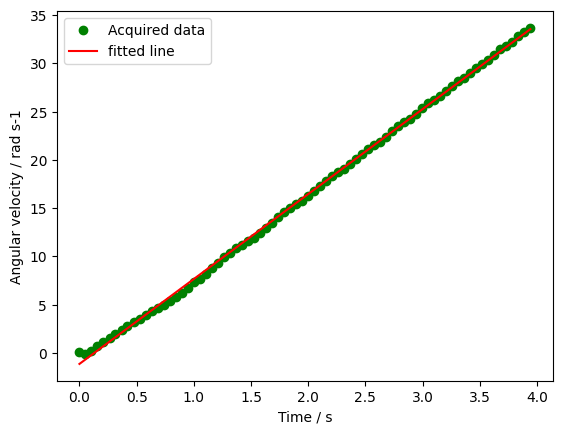

DoF: 74, slope (95%): 8.7949 +/- 0.0532 (rad s-2)
intercept (95%): -1.1367 +/- 0.1215 (rad s-1)


In [9]:
timeAbs = np.array(exp_df['_time'].astype(np.int64)) / 1.0e9
timeRel = timeAbs - timeAbs[0]
gyroZ = np.array(exp_df['gyro.z'].astype(np.float64)) / 180 * np.pi 

# Calculate a linear least-squares regression for two sets of measurements.
# slope, intercept, r, p, se = linregress(timeRel, gyroZ)
result = linregress(timeRel, gyroZ)

fig = plt.figure()  # figsize=(5, 4))
#ax = fig.add_subplot(autoscale_on=True) # , xlim=(-L, L), ylim=(-L, 1.))
# ax.grid()

plt.plot(timeRel, gyroZ, 'o', label='Acquired data', color="green")
plt.plot(timeRel, result.intercept + result.slope* timeRel, '-', color="red", label='fitted line')

#fig.canvas.header_visible = False
plt.ylabel("Angular velocity / rad s-1")
plt.xlabel("Time / s")
plt.savefig('AngAccel.png')
plt.legend()
plt.show()
# Two-sided inverse Students t-distribution
# p - probability, df - degrees of freedom
from scipy.stats import t
tinv = lambda p, df: abs(t.ppf(p/2, df))
ts = tinv(0.05, len(timeRel) - 2)
gamma = result.slope
Dgamma = ts*result.stderr
print(f"DoF: {len(timeRel) - 2}, slope (95%): {gamma:.4f} +/- {Dgamma:.4f} (rad s-2)")
print(f"intercept (95%): {result.intercept:.4f}"
      f" +/- {ts*result.intercept_stderr:.4f} (rad s-1)")

In [10]:
Igz = lambda accel, m, r, g:  m * (g * r   - accel * r**2) / accel
I_MW = Igz(gamma, 0.5158, 2.51e-3, 9.801)
print(f"I_gz: {I_MW:.5f} (kg m2)")
dIgz = lambda accel, m, r, g, eaccel:  m * g * r  / accel **2 * eaccel
dI_MW = dIgz(gamma, 0.5158, 2.51e-3, 9.801, Dgamma )
print(f"I_gz: {I_MW:.5f} +- {dI_MW:.7f} (kg m2)")

I_gz: 0.00144 (kg m2)
I_gz: 0.00144 +- 0.0000087 (kg m2)


start_time = '14:35:48.900'
end_time = '14:35:52.800'
DoF: 72, slope (95%): 8.8434 +/- 0.0239 (rad s-2)
intercept (95%): 0.2022 +/- 0.0531 (rad s-1)
I_gz: 0.00143 (kg m2)
I_gz: 0.00143 +- 0.0000039 (kg m2)

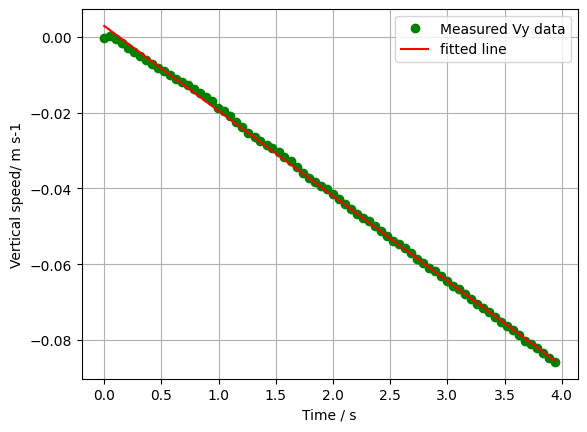

slope (95%): -0.0224 +/- 0.0001 (m s-2)
intercept (95%): 0.0029 +/- 0.0003 (m s-1)


In [11]:
# Axys Radius
r = 0.0051/2 
velY = - r * gyroZ
result = linregress(timeRel, velY)

fig = plt.figure()  # figsize=(5, 4))
ax = fig.add_subplot()  # autoscale_on=False) # , xlim=(-L, L), ylim=(-L, 1.))
ax.grid()
ax.plot(timeRel, velY, 'o', label='Measured Vy data', color="green")
ax.plot(timeRel, result.intercept + result.slope* timeRel, 'r', label='fitted line')
plt.legend()
#fig.canvas.header_visible = False
plt.ylabel("Vertical speed/ m s-1")
plt.xlabel("Time / s")
plt.legend()
plt.show()

# Two-sided inverse Students t-distribution
# p - probability, df - degrees of freedom
from scipy.stats import t
tinv = lambda p, df: abs(t.ppf(p/2, df))
ts = tinv(0.05, len(timeRel) - 2)
print(f"slope (95%): {result.slope:.4f} +/- {ts*result.stderr:.4f} (m s-2)")
print(f"intercept (95%): {result.intercept:.4f}"
      f" +/- {ts*result.intercept_stderr:.4f} (m s-1)")

 $ s_z(t) = \frac{1}{2} \frac{mg}{m +  \frac{Iz}{r^2}} \cdot t^2$, $ v_z(t) = \frac{mg}{m +  \frac{Iz}{r^2}} \cdot t$   

$ E_{kin} =   \frac{1}{2} m  v^2 + \frac{1}{2}  I_z w^2 =  \frac{1}{2} ( m  (r w )^2 +  I_z w^2)$  
$ E_{kin}  =  E_{trans} +  E_{rot} =  \frac{1}{2} ( m r^2 +  I_z) w^2$  
$ \frac{dE_{kin}}{dt} =   ( m r^2 +  I_z) w \, \dot{w} $   
$ \frac{dE_{pot}}{dt}  =  - \vec{F_g} \times \vec{v}(t) = -m g \cdot r w(t)$  

$ \frac{dE_{tot}}{dt} =  -m g \, r w    + ( m r^2 +  I_z) w \dot{w} $   

$ \frac{dE_{tot}}{dt}=0  \to  \dot{w} \equiv \gamma = \frac{m g  r}{m r^2 +  I_z} $    

$ \gamma = \frac{ g  r}{ r^2 +  I_z / m} $    
$ \gamma ( r^2 +  I_z /m)  =  g  r $ 

$ Iz =  m \frac{ g  r  - \gamma  r^2  }{\gamma}  =   m  r\frac{ g  - \gamma  r }{\gamma} =   m  r (\frac{ g   }{\gamma} - r ) $ 


$ \gamma = m r^2   I_z \to I_z = \gamma - \frac{m}{r^2}$  
$ \theta_z(t) = \frac{1}{2} (m v  + Iz ) \cdot t^2$,  
$ s_z(t) = \frac{1}{2} \frac{mg}{m +  \frac{Iz}{r^2}} \cdot t^2$,
$A_{v_z} = \frac{mg}{m +  \frac{Iz}{r^2}}$ 
$ \omega_y(t) =  r * v(t)$  
$ \vec{\omega}_y(t) = \vec{r} \times \vec{v}(t)$
$ \omega_y(t) =  r \frac{mg}{m +  \frac{Iz}{r^2}} \cdot t$  

$ \omega_y(t) =  r \frac{r^2 mg}{ r^2 m +  \frac{Iz}{1}} \cdot t$  

 

In [15]:
# initial value for the state (angle and angular velocity). 
# System parameters
#m = 1  # mass
gamma = 8  ## angular accel rad s-2)' 
#b = 2  # damping coefficient

x = np.array([[0.],     # angle / rad
                [0.]])  # angular velocity (w /rad s-1)
# Define the state transition matrix:
A = np.array([[0.,1.],
                [0.,0.]])
# Input matrix
B = np.array([[0],
              [gamma]])
# Output matrix
C = np.array([1,0]) # angle

#C = np.array([0,1]) # angular velocity
# Direct feedthrough matrix
D = np.array([0])

# Create the state-space model
sys = ct.ss(A, B, C, D, inputs=['accel'], outputs=['y1', 'y2'])
# Print the state-space model
print(sys)
# Simulate the step response
T, yout = ct.step_response(sys,  T=np.linspace(0, 5, 100))

# Plot the step response
fig = plt.figure()  # figsize=(5, 4))
ax = fig.add_subplot()  # autoscale_on=False) # , xlim=(-L, L), ylim=(-L, 1.))
ax.grid()
ax.plot(T, np.cos(yout), label='Cos')
ax.plot(T, np.sin(yout), label='Sin')
plt.xlabel("Time (sec)")
plt.ylabel("Angular")
plt.legend()
plt.show()

ValueError: C and D must have the same number of rows.

In [ ]:
yout.shape

In [ ]:
# Create the state-space model with Discrete Time Systems
# with sampling period dt
dt = 0.05
# Define the state transition matrix:
Adt = np.array([[0.,dt],
                [0.,0.]])
# Input matrix
Bdt = np.array([[0],
              [gamma * dt]])
# Output matrix
#C = np.array([1,0]) # angle
C = np.array([0,1]) # angular velocity
# Direct feedthrough matrix
D = np.array([0])
sys = ct.ss(Adt, Bdt, C, D, dt)
# Print the state-space model
print(sys)
# Simulate the step response
T, yout = ct.step_response(sys)

# Plot the step response
fig = plt.figure()  # figsize=(5, 4))
ax = fig.add_subplot()  # autoscale_on=False) # , xlim=(-L, L), ylim=(-L, 1.))
ax.grid()
ax.plot(T, yout, label='Me')
plt.xlabel("Time (sec)")
plt.ylabel("Angular speed")
plt.legend()
plt.show()

In [ ]:
# System parameters
m = 1  # mass
k = 3  # spring constant
b = 2  # damping coefficient

# State matrix
A = np.array([[0,1],
              [-k/m, -b/m]])

# Input matrix
B = np.array([[0],
              [1/m]])

# Output matrix
C = np.array([1,0])

# Direct feedthrough matrix
D = np.array([0])

# Create the state-space model
sys = ct.ss(A, B, C, D)

# Print the state-space model
print(sys)
# Simulate the step response
T, yout = ct.step_response(sys)

# Plot the step response
fig = plt.figure()  # figsize=(5, 4))
ax = fig.add_subplot()  # autoscale_on=False) # , xlim=(-L, L), ylim=(-L, 1.))
ax.grid()
ax.plot(T, yout)
plt.xlabel("Time (sec)")
plt.ylabel("Output")
#plt.legend()
plt.show()

In [ ]:
Iz = lambda A, m, r, g: m * (g - A) / A * r**2
I_MW = Iz(result.slope, 0.5158, 2.51e-3, 9.801)
print(f"I_z: {I_MW:.5f} (kg m2)")

In [ ]:
#%matplotlib notebook
# %matplotlib inline
from  ipywidgets import AppLayout, interact
import ipywidgets as widgets
%matplotlib ipympl
# plt.ioff()
start_time = '14:35:48.9'
end_time = '14:35:53'
exp_df = select_data(imu_df, DATE, start_time, end_time)
fig = plt.figure() #  figsize=plt.figaspect(0.5))
fig.canvas.header_visible = False
plt.ylabel("Angular velocity / rad s-1")
plt.xlabel("Time / s")
time = np.array(exp_df['_time'].astype(np.int64)) / 1.0e9
gyroZ = np.array(exp_df['gyro.z'].astype(np.float64)) / 180 * np.pi 
timeRel = time - time[0]
x = np.linspace(timeRel[0], timeRel[-1], 20)
line, = plt.plot(timeRel, gyroZ, color="green")
#b=-3
lineFit = plt.plot(x, x*2, linestyle='--', color="black")
def update_fit(m : float , t0: float):
    lineFit[0].set_data(x, m * (x -t0))
    plt.show()
mSlider = widgets.FloatSlider(min=0.0, max=10.0, step=0.1, value=3,)
t0Slider = widgets.FloatSlider(min=-10.0, max=20.0, step=0.1, value=1,)
interact(update_fit, m=mSlider, t0=t0Slider);


In [ ]:
type(time)
time.astype
print(f"Accel {mSlider.value} rad s-2") 
print(f"Accel {mSlider.value * 2.505e-3} m s-2")  # w = v / r

In [ ]:
def position_XY(time,  time0=0, accelZ=9.0, theta0=0.0, gX = 1.0, gY=1.0):
    """
    time:
    accelZ: wheel fall angular accelaration
    gX: max g in 
    """
    theta = np.ones(time.shape) * theta0
    # b = np.where(time<time0,0,1)
    theta[time > time0] = theta0 + 1 / 2 * accelZ * (time[time > time0] -time0)**2
    return np.cos(theta), -np.sin(theta)
    

In [ ]:
fig = plt.figure() #  figsize=plt.figaspect(0.5))
#fig.canvas.header_visible = False
plt.ylabel("Accel / rad s-2")
plt.xlabel("Time / s")
accelX = np.array(exp_df['accel.x'].astype(np.float64))
accelY = np.array(exp_df['accel.y'].astype(np.float64))
x = np.linspace(timeRel[0], timeRel[-1], 20)
plt.plot(timeRel, accelX, color="red")
line, = plt.plot(timeRel, accelY, color="blue")
aX, aY = position_XY(timeRel, t0Slider.value, mSlider.value, theta0=0, gX = 1.0, gY=1.0)
plt.plot(timeRel, aX, linestyle='--', color="red")
plt.plot(timeRel, aY, linestyle='--', color="blue")
plt.show()

 $ A = \frac{mg}{ m + \frac{I_z}{r^2}}$   
 $A \frac{I_z}{r^2} = m (g - A )$  
  $I_z = m \frac{g - A}{A} r^2$  

In [ ]:
def Iz(A, m, r, g):
    return m* (A-g) / A * r**2
Iz(0.022044, 0.585, 2.5e-3, 9.8)

In [ ]:
np.ones(timeRel.shape)

In [ ]:
time[0]